<a href="https://colab.research.google.com/github/PrabhuKiran8790/NLP/blob/main/Final_NLP_Project_BI_LSTM_BERT_EMBEDDINGS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download Preprocessed Data
- data preprocessing notebook can be found <a href="https://github.com/PrabhuKiran8790/NLP/blob/main/final-project/bi_lstm_nlp_data_preprocessing.ipynb">here</s>

In [1]:
!gdown 1Umtz-Un9pXTgdPrN22mZiw-qCHXGd7ls

Downloading...
From: https://drive.google.com/uc?id=1Umtz-Un9pXTgdPrN22mZiw-qCHXGd7ls
To: /content/df_cleaned_train_test_val_.pkl
100% 2.38M/2.38M [00:00<00:00, 157MB/s]


In [2]:
import pickle

cleaned_data = None
with open('/content/df_cleaned_train_test_val_.pkl', 'rb') as f:
    cleaned_data = pickle.load(f)

In [3]:
df_cleaned_train = cleaned_data['df_cleaned_train']
df_test = cleaned_data['df_test']
df_val = cleaned_data['df_val']

In [4]:
df_cleaned_train

,Input,Sentiment,Length
0,i do not feel humiliate,3,23
1,i can go from feel so hopeless to so damn hope...,3,108
2,i m grab a minute to post i feel greedy wrong,1,48
3,i am ever feel nostalgic about the fireplace i...,2,92
4,i am feel grouchy,1,20
...,...,...,...
15995,i just have a very brief time in the beanbag a...,3,101
15996,i am now turn and i feel pathetic that i am st...,3,102
15997,i feel strong and good overall,0,30
15998,i feel like this was such a rude comment and i...,1,59


In [5]:
import pandas as pd
import numpy as np
from keras.preprocessing.text import Tokenizer

In [6]:
!pip install --upgrade tensorflow_hub -q

In [7]:
df_train_inputs = df_cleaned_train.Input.tolist()

# BERT
- BERT for embedding

In [8]:
import tensorflow_hub as hub

emb_model = hub.KerasLayer("https://tfhub.dev/google/nnlm-en-dim128/2")
embeddings = emb_model(df_train_inputs)
print(embeddings.shape)

(16000, 128)


In [9]:
X_val_emb = emb_model(df_val.Input.tolist())

In [10]:
from keras.utils import to_categorical
y_train = to_categorical(df_cleaned_train.Sentiment.values)
y_test = to_categorical(df_test.Sentiment.values)
y_val = to_categorical(df_val.Sentiment.values)

In [11]:
num_words = 16000
tokenizer = Tokenizer(num_words,lower=True)
df_total = pd.concat([df_cleaned_train['Input'], df_test.Input], axis = 0)
tokenizer.fit_on_texts(df_total)

In [12]:
from keras_preprocessing.sequence import pad_sequences

X_train = tokenizer.texts_to_sequences(df_cleaned_train['Input']) # texts -> numeric sequences 
X_train_pad = pad_sequences(X_train, maxlen=300, padding='post') # length of all numeric sequences equal

X_test = tokenizer.texts_to_sequences(df_test.Input)
X_test_pad = pad_sequences(X_test, maxlen = 300, padding = 'post')

X_val = tokenizer.texts_to_sequences(df_val.Input)
X_val_pad = pad_sequences(X_val, maxlen = 300, padding = 'post')

In [13]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional, Input
import tensorflow as tf
# tf.compat.v1.keras.layers.CuDNNLSTM
from tensorflow.compat.v1.keras.layers import CuDNNLSTM, CuDNNGRU
from tensorflow.keras.layers import Dropout

# Model Architecture

In [14]:
EMBEDDING_DIM = 128 # this means the embedding layer will create  a vector in 128 dimension

model = Sequential()
model.add(Embedding(input_dim = num_words, # the whole vocabulary size 
                    output_dim = EMBEDDING_DIM, # vector space dimension
                    input_length= X_train_pad.shape[1], # max_len of text sequence
                    weights = [embeddings],trainable = False))

model.add(Dropout(0.2))
model.add(Bidirectional(CuDNNLSTM(100,return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(CuDNNLSTM(200,return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(CuDNNLSTM(100,return_sequences=False)))
model.add(Dense(6, activation = 'softmax'))


model.compile(loss = 'categorical_crossentropy',
              optimizer = 'adam',
              metrics = 'accuracy')

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 128)          2048000   
                                                                 
 dropout (Dropout)           (None, 300, 128)          0         
                                                                 
 bidirectional (Bidirectiona  (None, 300, 200)         184000    
 l)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 300, 200)          0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 300, 400)         643200    
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 300, 400)          0

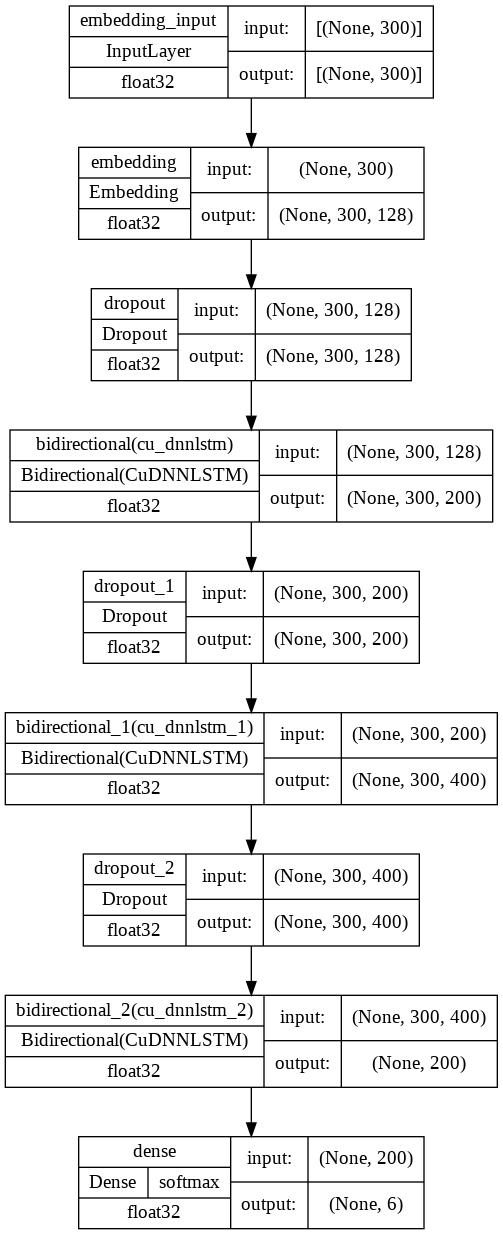

In [16]:
tf.keras.utils.plot_model(model, show_shapes=True, show_dtype=True, show_layer_activations=True)

In [17]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 10)
mc = ModelCheckpoint('./model.h5', monitor = 'val_accuracy', mode = 'max', verbose = 1, save_best_only = True)

In [18]:
history_embedding = model.fit(X_train_pad,
                              y_train,
                              epochs = 50,
                              batch_size = 128,
                              validation_data=(X_val_pad, y_val),
                              verbose = 1,
                              callbacks=[es, mc])

Epoch 1/50
125/125 [==============================] - ETA: 0s - loss: 1.5820 - accuracy: 0.3336
Epoch 1: val_accuracy improved from -inf to 0.35050, saving model to ./model.h5
125/125 [==============================] - 36s 204ms/step - loss: 1.5820 - accuracy: 0.3336 - val_loss: 1.5773 - val_accuracy: 0.3505
Epoch 2/50
125/125 [==============================] - ETA: 0s - loss: 1.5752 - accuracy: 0.3413
Epoch 2: val_accuracy did not improve from 0.35050
125/125 [==============================] - 24s 189ms/step - loss: 1.5752 - accuracy: 0.3413 - val_loss: 1.5807 - val_accuracy: 0.3505
Epoch 3/50
125/125 [==============================] - ETA: 0s - loss: 1.5680 - accuracy: 0.3484
Epoch 3: val_accuracy improved from 0.35050 to 0.35350, saving model to ./model.h5
125/125 [==============================] - 23s 187ms/step - loss: 1.5680 - accuracy: 0.3484 - val_loss: 1.5637 - val_accuracy: 0.3535
Epoch 4/50
125/125 [==============================] - ETA: 0s - loss: 1.5610 - accuracy: 0.3536


# Model Performance Visualization

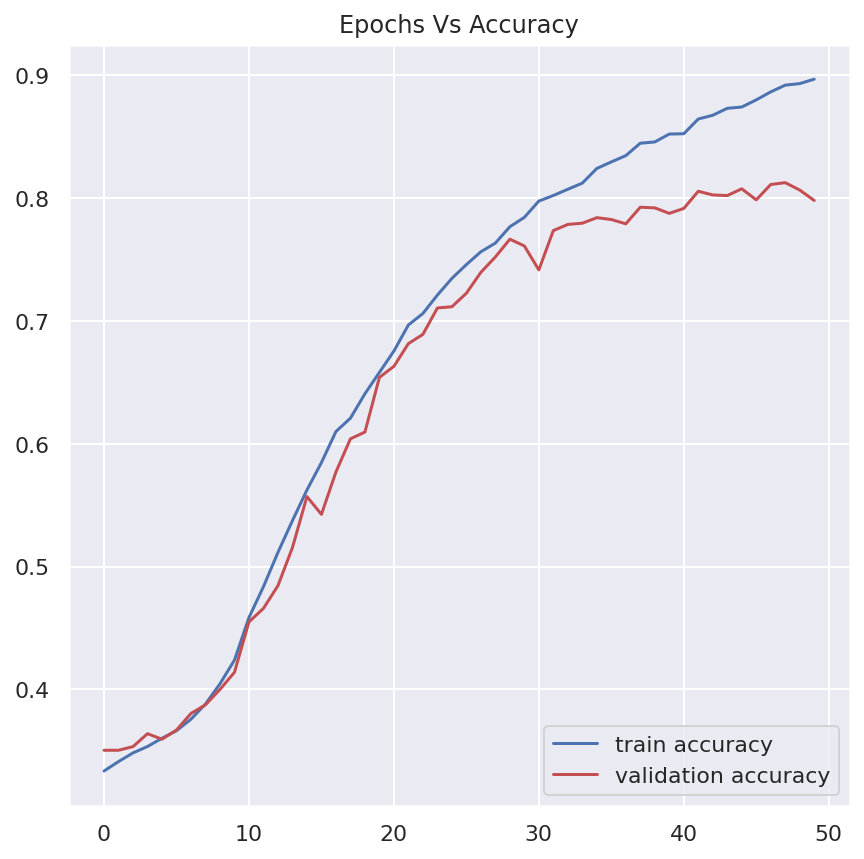

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%config InlineBackend.figure_format = 'retina'

plt.rcParams["figure.figsize"] = (7,7)
plt.plot(history_embedding.history['accuracy'],c='b',label='train accuracy')
plt.plot(history_embedding.history['val_accuracy'],c='r',label='validation accuracy')
plt.legend(loc='lower right')
plt.title("Epochs Vs Accuracy")
plt.show()

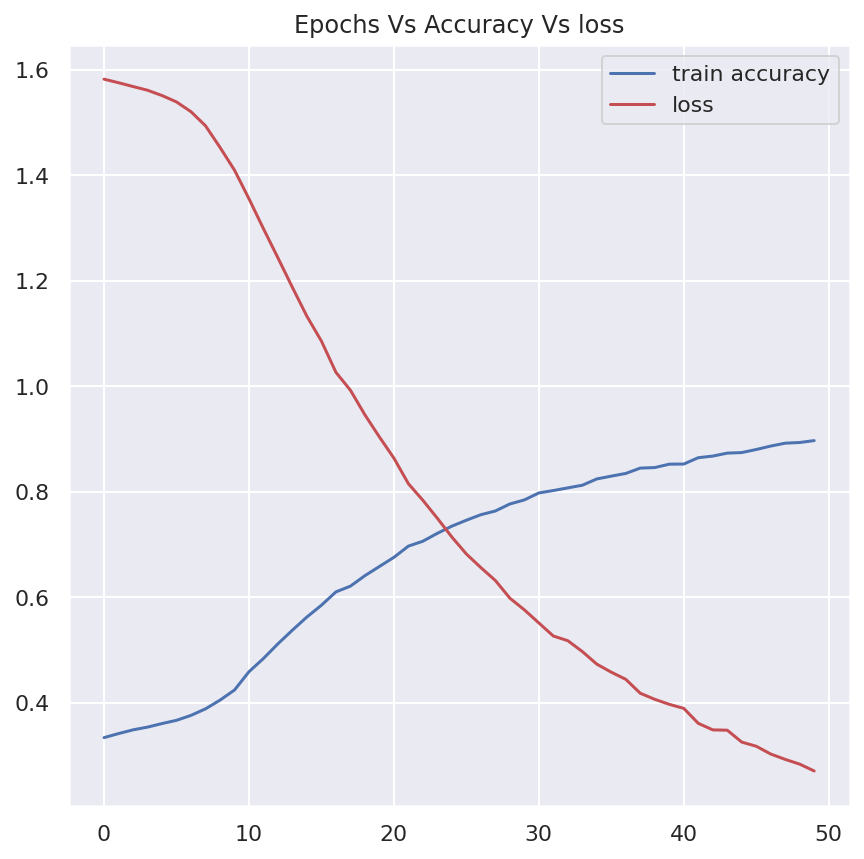

In [20]:
plt.rcParams["figure.figsize"] = (7,7)
plt.plot(history_embedding.history['accuracy'],c='b',label='train accuracy')
plt.plot(history_embedding.history['loss'],c='r',label='loss')
plt.legend(loc='upper right')
plt.title("Epochs Vs Accuracy Vs loss")
plt.show()

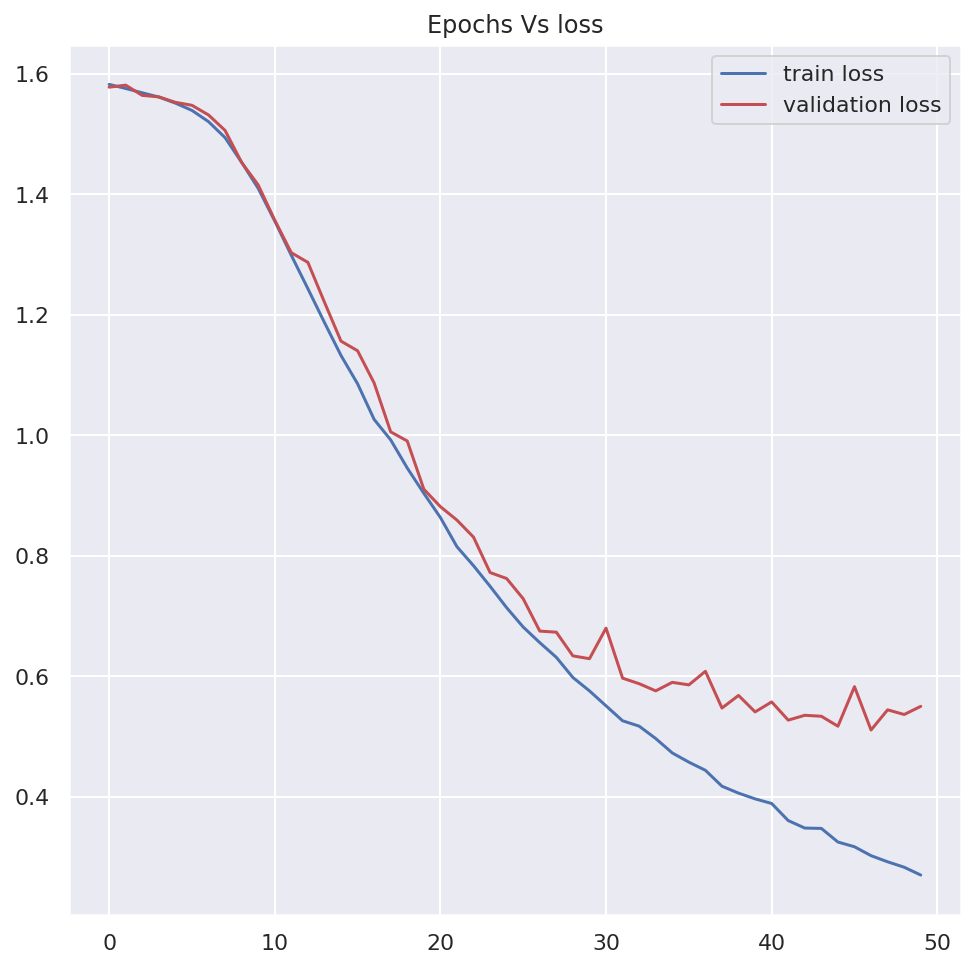

In [21]:
plt.rcParams["figure.figsize"] = (8,8)
plt.plot(history_embedding.history['loss'],c='b',label='train loss')
plt.plot(history_embedding.history['val_loss'],c='r',label='validation loss')
plt.legend(loc='upper right')
plt.title("Epochs Vs loss")
plt.show()

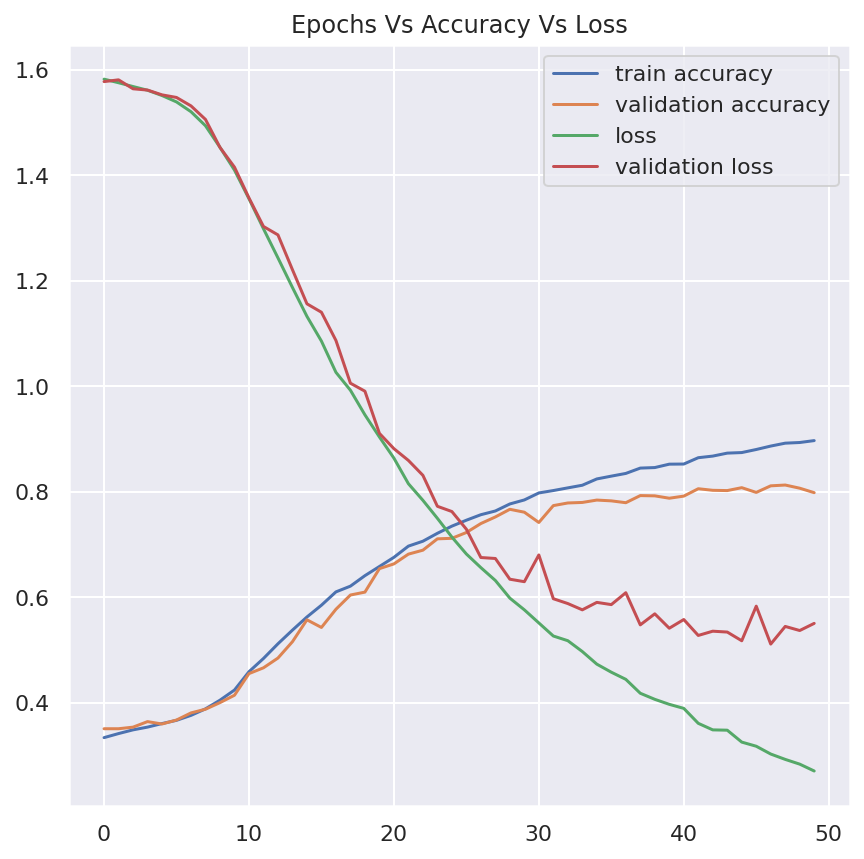

In [22]:
plt.rcParams["figure.figsize"] = (7,7)
plt.plot(history_embedding.history['accuracy'],label='train accuracy')
plt.plot(history_embedding.history['val_accuracy'],label='validation accuracy')
plt.plot(history_embedding.history['loss'],label='loss')
plt.plot(history_embedding.history['val_loss'],label='validation loss')
plt.legend(loc='upper right')
plt.title("Epochs Vs Accuracy Vs Loss")
plt.show()

In [23]:
model.evaluate(X_test_pad, y_test)

63/63 [==============================] - 2s 36ms/step - loss: 0.5491 - accuracy: 0.8085


[0.5490743517875671, 0.8084999918937683]

In [24]:
y_pred = np.argmax(model.predict(X_test_pad), axis  =  1)

63/63 [==============================] - 3s 31ms/step


In [25]:
y_true = np.argmax(y_test, axis = 1)

In [26]:
from sklearn import metrics
print(metrics.classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.88      0.84       695
           1       0.73      0.83      0.77       275
           2       0.76      0.59      0.66       159
           3       0.88      0.79      0.83       581
           4       0.85      0.79      0.82       224
           5       0.70      0.73      0.71        66

    accuracy                           0.81      2000
   macro avg       0.79      0.77      0.77      2000
weighted avg       0.81      0.81      0.81      2000



In [27]:
model.save('bi-lstm-bert_embedding_classification.h5')

In [28]:
dictionary = {
    'joy' : 0,
    'anger' : 1,
    'love' : 2,
    'sadness' : 3,
    'fear' : 4,
    'surprise' : 5
    }

get_label = {val : key for key, val in dictionary.items()}
get_label

{0: 'joy', 1: 'anger', 2: 'love', 3: 'sadness', 4: 'fear', 5: 'surprise'}

In [29]:
def predict(sentence: str, model):
    get_label = {0: 'joy', 1: 'anger', 2: 'love', 3: 'sadness', 4: 'fear', 5: 'surprise'}
    sentence_lst=[]
    sentence_lst.append(sentence)
    sentence_seq = tokenizer.texts_to_sequences(sentence_lst)
    sentence_padded = pad_sequences(sentence_seq, maxlen=300, padding='post')    
    pred = get_label[np.argmax(model.predict(sentence_padded))]
    print(f'{sentence} : {pred}')

In [30]:
predict("i feel so threatened", model)

1/1 [==============================] - 0s 101ms/step
i feel so threatened : fear


In [31]:
tests = [
    'i am so lucky to get placed in my favourite company',
    'i hate that person. he is so rude to me for no reason',
    'i feel down. i could not cover the whole syllabus',
    'i feel so threatened',
    'to my utter surprise, he actually cleared the exam'
]

for e in tests:
    predict(e, model)

1/1 [==============================] - 0s 18ms/step
i am so lucky to get placed in my favourite company : joy
1/1 [==============================] - 0s 16ms/step
i hate that person. he is so rude to me for no reason : anger
1/1 [==============================] - 0s 17ms/step
i feel down. i could not cover the whole syllabus : sadness
1/1 [==============================] - 0s 20ms/step
i feel so threatened : fear
1/1 [==============================] - 0s 17ms/step
to my utter surprise, he actually cleared the exam : surprise


In [32]:
def batch_predict(sentence: str, model):
    get_label = {0: 'joy', 1: 'anger', 2: 'love', 3: 'sadness', 4: 'fear', 5: 'surprise'}
    sentence_lst=[]
    sentence_lst.append(sentence)
    sentence_seq = tokenizer.texts_to_sequences(sentence_lst)
    sentence_padded = pad_sequences(sentence_seq, maxlen=300, padding='post')    
    pred = np.argmax(model.predict(sentence_padded, verbose=0))
    return pred

In [33]:
test_df_actual_labels = df_test.Sentiment.tolist()

In [34]:
test_df_inputs = df_test.Input.tolist()

In [35]:
test_preds = [batch_predict(i, model) for i in test_df_inputs]

In [36]:
get_label = {0: 'joy', 1: 'anger', 2: 'love', 3: 'sadness', 4: 'fear', 5: 'surprise'}
class_names = [get_label[i] for i in range(6)]

In [37]:
df_test_comparision_df = df_test.copy()
df_test_comparision_df

,Input,Sentiment
0,im feeling rather rotten so im not very ambiti...,3
1,im updating my blog because i feel shitty,3
2,i never make her separate from me because i do...,3
3,i left with my bouquet of red and yellow tulip...,0
4,i was feeling a little vain when i did this one,3
...,...,...
1995,i just keep feeling like someone is being unki...,1
1996,im feeling a little cranky negative after this...,1
1997,i feel that i am useful to my people and that ...,0
1998,im feeling more comfortable with derby i feel ...,0


In [38]:
df_test_comparision_df['predicted_sentiment'] = test_preds

In [39]:
df_test_comparision_df

,Input,Sentiment,predicted_sentiment
0,im feeling rather rotten so im not very ambiti...,3,3
1,im updating my blog because i feel shitty,3,3
2,i never make her separate from me because i do...,3,3
3,i left with my bouquet of red and yellow tulip...,0,0
4,i was feeling a little vain when i did this one,3,3
...,...,...,...
1995,i just keep feeling like someone is being unki...,1,1
1996,im feeling a little cranky negative after this...,1,1
1997,i feel that i am useful to my people and that ...,0,0
1998,im feeling more comfortable with derby i feel ...,0,0


In [40]:
length = len(df_test_comparision_df)
mis_matches_inputs = []
actual_mismatch = []
predicted_mismatch = []

for i in range(length):
    if df_test_comparision_df.loc[i, 'Sentiment'] != df_test_comparision_df.loc[i, 'predicted_sentiment']:
        mis_matches_inputs.append(df_test_comparision_df.iloc[i, 0])
        actual_mismatch.append(get_label[df_test_comparision_df.loc[i, 'Sentiment']])
        predicted_mismatch.append(get_label[df_test_comparision_df.loc[i, 'predicted_sentiment']])


mis_matches = pd.DataFrame(np.column_stack([mis_matches_inputs, actual_mismatch, predicted_mismatch]), 
                               columns=['Inputs', 'Actual', 'Predicted'])

mis_matches

,Inputs,Actual,Predicted
0,i felt anger when at the end of a telephone call,anger,fear
1,i don t feel particularly agitated,fear,anger
2,i pay attention it deepens into a feeling of b...,fear,joy
3,i was feeling as heartbroken as im sure katnis...,sadness,joy
4,i feel like my only role now would be to tear ...,sadness,anger
...,...,...,...
378,i am now and i still feel the aching lonelines...,sadness,joy
379,i dont want to always be judgmental of particu...,sadness,joy
380,im feeling cooped up and impatient and annoyin...,anger,fear
381,i have found myself fighting back as he wakes ...,sadness,love


In [41]:
mis_matches.Actual.value_counts()

sadness     120
joy          85
love         65
fear         48
anger        47
surprise     18
Name: Actual, dtype: int64

In [42]:
mis_matches.Predicted.value_counts()

joy         153
anger        86
sadness      63
fear         30
love         30
surprise     21
Name: Predicted, dtype: int64

In [43]:
actual_inputs_dict = dict(mis_matches.Actual.value_counts())
predicted_output_dict = dict(mis_matches.Predicted.value_counts())

In [44]:
comparision = {}

for e in actual_inputs_dict:
    comparision[e] = predicted_output_dict[e] - actual_inputs_dict[e]
comparision

{'sadness': -57,
 'joy': 68,
 'love': -35,
 'fear': -18,
 'anger': 39,
 'surprise': 3}

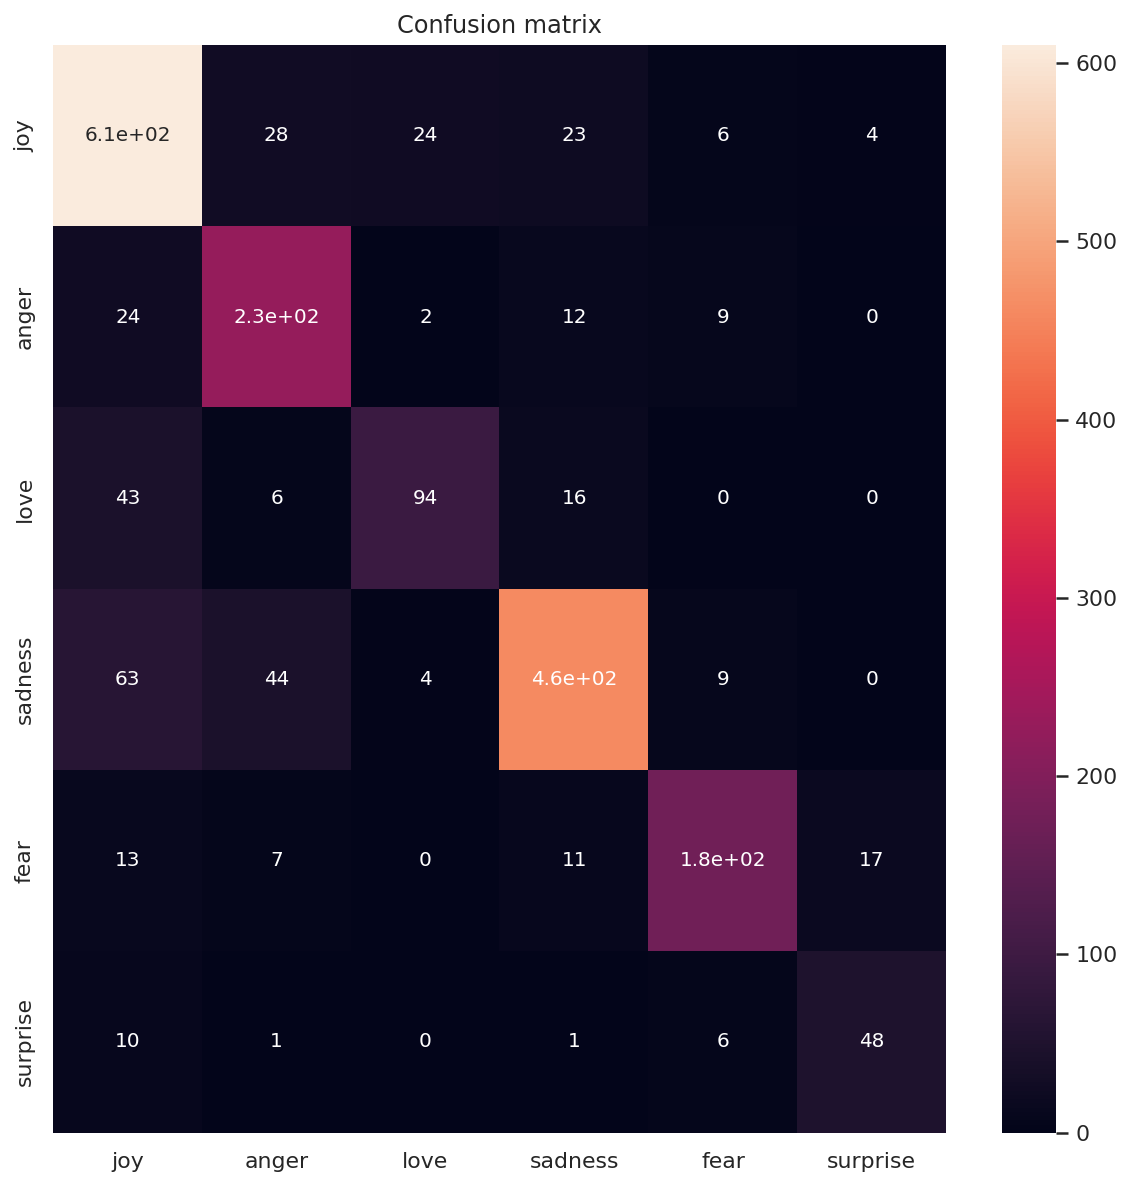

In [45]:
from sklearn.metrics import confusion_matrix

get_label = {0: 'joy', 1: 'anger', 2: 'love', 3: 'sadness', 4: 'fear', 5: 'surprise'}
class_names = get_label.values()

plt.rcParams["figure.figsize"] = (10,10)
CM = confusion_matrix(test_df_actual_labels, test_preds)
ax = plt.axes()
sns.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Confusion matrix')
plt.show()

In [46]:
history_embedding.history['accuracy'][-1], history_embedding.history['val_accuracy'][-1]

(0.8967499732971191, 0.7979999780654907)

In [48]:
history_embedding.history['loss'][-1], history_embedding.history['val_loss'][-1]

(0.27035558223724365, 0.5502386093139648)